In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F


debug = True

# TODO stride=2 is used in the paper but this is causing shape issues right now :(
def conv_3x3(in_channels, out_channels, pad=1, stride=1):
    return nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=pad)


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        A ResidualBlock implements the basic residual block discussed in the paper, for the network used on CIFAR 10.
        It consists of a pair of 3x3 convolutional layers, all with the same output feature map size (either 32, 16, or 8)
        We apply conv-BN-relu for the first layer, then conv-BN, then add the input (residual connection) and do a final RELU.
        We zero-pad the input for dimension mismatches, so that no new parameters are introduced in the residual connections.
        """
        self.in_channels, self.out_channels = in_channels, out_channels
        super(ResidualBlock, self).__init__()
        self.conv1 = conv_3x3(in_channels, in_channels)
        self.bn1 = nn.BatchNorm2d(num_features=in_channels)
        self.conv2 = conv_3x3(in_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(num_features=out_channels)

        
    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        # The paper said that identity shortcuts are used in all cases, 
        # so in cases of shape mismatch I pad to align dimensions, which introduces no new parameters.
        if x.shape != identity.shape:
            shape_diff = abs((sum(identity.shape) - sum(x.shape)))
            identity = F.pad(identity, pad=(0,0,0,0,shape_diff//2,shape_diff//2))
        x = F.relu(identity + x)
        return x

    def __repr__(self):
        return f'Residual block with in_channels {self.in_channels} and out channels {self.out_channels}'


class Resnet(nn.Module):
    def __init__(self, n=1, dbg=False):
        super(Resnet, self).__init__()
        debug = dbg
        self.residual_blocks = []
        # create number of residual blocks needed
        cur_feature_map_size = 16
        changed = False
        for i in range(3*n):
            if i != 0 and i % n == 0:
                cur_feature_map_size = cur_feature_map_size*2
                changed = True
            block = ResidualBlock(cur_feature_map_size if not changed else cur_feature_map_size//2, cur_feature_map_size)
            changed = False
            self.residual_blocks.append(block)

        self.linear = nn.Linear(16384, 10)
        self.conv1 = conv_3x3(3, 16)
        self.pool = nn.AvgPool2d(2, stride=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        for block in self.residual_blocks:
            x = block(x)
        # x = self.first_block(x)
        # flatten the multidimensional input to a single matix for input into the FC layer
        x = self.pool(x) # only difference is this pool
        x = x.view(x.shape[0], -1)
        x = self.linear(x)
        return x

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
import numpy as np

def get_dataset():
    transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=1)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False, num_workers=1)
    return trainloader, testloader 

def get_test_accuracy(net, testloader):
  accs = []
  net.eval()
  with torch.no_grad():
    for i, data in enumerate(testloader, 0):
      x, y = data
      x, y = x.cuda(), y.cuda()
      preds = resnet(x)
      _, predicted = torch.max(preds, 1)
      accuracy = accuracy_score(predicted.cpu(), y.cpu())
      accs.append(accuracy)
      break
  net.train()
  return np.mean(accs)

def update_learning_rate(current_lr, optimizer):
  new_lr = current_lr/10
  for g in optimizer.param_groups:
    g['lr'] = new_lr
  return new_lr



if __name__ == '__main__':
    num_epochs = 80
    # get cifar 10 data
    trainloader, testloader = get_dataset()
    benchmark, debug = False, True
    resnet = Resnet(n=2,dbg=debug)
    resnet.train()
    resnet = resnet.cuda()
    for block in resnet.residual_blocks:
      block.cuda()
    current_lr = 1e-4
#     optimizer = optim.SGD(resnet.parameters(), lr=current_lr, weight_decay=0.0001, momentum=0.9)
    optimizer = optim.Adam(resnet.parameters(), lr=1e-4, weight_decay=0.0001)
    train_accs, test_accs = [], []
    gradient_norms = []
    def train_model():
      current_lr=1e-4
      stopping_threshold, current_count = 3, 0
      n_iters = 0
      for e in range(num_epochs):
        # modify learning rate at 
          for i, data in enumerate(trainloader, 0):
              x, y = data
              x, y = x.cuda(), y.cuda()
              # zero the grad
              optimizer.zero_grad()
              preds = resnet(x)
              loss = F.cross_entropy(preds, y)
              loss.backward()
              optimizer.step()
              if i % 10 == 0:
                  _, predicted = torch.max(preds, 1)
                  accuracy = accuracy_score(predicted.cpu(), y.cpu())
                  train_accs.append(accuracy)
                  print('n_iters: {} loss: {}, accuracy: {}'.format(n_iters, loss, accuracy))
              if i % 50 == 0:
                # get test accuracy
                test_acc = get_test_accuracy(resnet, testloader)
                test_accs.append(test_acc)
                # monitor gradient norms
                total_norm = sum([p.grad.data.norm(2).item() ** 2 for p in resnet.parameters()])
                total_norm**=(1./2)
                gradient_norms.append(total_norm)
                print('n_iters: {} test accuracy: {} gradient_norm: {}'.format(n_iters, test_acc, total_norm))
              n_iters+=1
              if n_iters == 10000 or n_iters == 16000 or n_iters == 24000:
                current_lr = update_learning_rate(current_lr, optimizer)
                print('decayed learning rate to {}'.format(current_lr))
      print('iterated {} times'.format(n_iters))
      return resnet, n_iters, train_accs, test_accs
    
    trained_resnet, n_iters, train_accs, test_accs, gradient_norms = train_model()
    
                



Files already downloaded and verified
Files already downloaded and verified
n_iters: 0 loss: 2.3997092247009277, accuracy: 0.1484375
n_iters: 0 test accuracy: 0.112 gradient_norm: 17.40572552328217
n_iters: 10 loss: 2.320924758911133, accuracy: 0.1328125
n_iters: 20 loss: 2.242439031600952, accuracy: 0.171875
n_iters: 30 loss: 2.271766185760498, accuracy: 0.1875
n_iters: 40 loss: 2.20607590675354, accuracy: 0.1328125
n_iters: 50 loss: 2.10225248336792, accuracy: 0.25
n_iters: 50 test accuracy: 0.189 gradient_norm: 11.573039621982213
n_iters: 60 loss: 2.1989784240722656, accuracy: 0.25
n_iters: 70 loss: 2.169342279434204, accuracy: 0.25
n_iters: 80 loss: 2.184079170227051, accuracy: 0.1796875
n_iters: 90 loss: 2.1422743797302246, accuracy: 0.2734375
n_iters: 100 loss: 2.134808301925659, accuracy: 0.265625
n_iters: 100 test accuracy: 0.217 gradient_norm: 13.074716923751454
n_iters: 110 loss: 2.2287118434906006, accuracy: 0.203125
n_iters: 120 loss: 2.07859206199646, accuracy: 0.2265625
n

2779 556 556


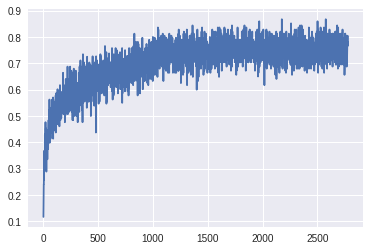

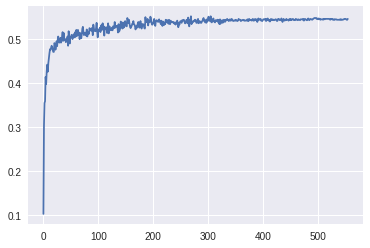

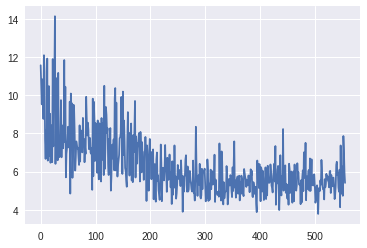

In [21]:
print(len(train_accs), len(test_accs), len(gradient_norms))
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(len(train_accs)), train_accs)
plt.show()
plt.plot(range(len(test_accs)), test_accs)
plt.show()
plt.plot(range(len(gradient_norms)), gradient_norms)

In [4]:
f

'hello'